<a href="https://colab.research.google.com/github/JohnnyT213/CDPHC2_sales_prediction/blob/main/NLP_Project_Practice_CDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Outline 

Business Problem - how do we sift through customer reviews at scale to improve business functions?

Bill Gates - "Unhappy customers give you one thing that happy customers don't--an opportunity to see where there are issues in your business."

Solution - Graded Sentiment Analysis with NLP to parse through text data, and Naive Bayes classifier to determine positive from negative reviews

#Why Sentiment Analysis?

**Sorting Data at Scale**

- Users make a lot of comments about brands, it is almost impossible to process them manually. Sentiment analysis enables businesses to automatically classify large amounts of raw data.

**Real-Time Analysis**

- Companies can learn the wishes of their customers by analyzing the social media comments about you in real time. They can identify the angry customer and ensure his satisfaction.

**Discovering New Marketing Strategies**

- With more data and information gathered through sentiment analysis, the organizations could develop an effective marketing strategy.

The outcome from the strategies can be measured from the customers’ positive or negative key messages.

By observing the customers’ conversations on their social media and detect the specific key messages related to your brand, specific marketing campaigns can be designed for the target consumers.

#Dataset

**Trip Advisor Hotel Reviews**
- 20K hotel reviews extracted from TripAdvisor

https://www.kaggle.com/code/emirkocak/in-depth-series-sentiment-analysis-w-transformers/data

Alam, M. H., Ryu, W.-J., Lee, S., 2016. Joint multi-grain topic sentiment: modeling semantic aspects for online reviews. Information Sciences 339, 206–223.

#Steps

- Graded Sentiment Analysis (assigning reviews as either positive or negative)
- Exploratory Data Visualization
- Topic Modeling 
- Machine Learning Classifiers (Naives Bayes, Vectorizer)

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/My Drive/tripadvisor_hotel_reviews.csv')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


5 - Very positive

4 - positive 

3 - neutral

2 - negative

1 - very negative

In [ ]:
df['Rating'].value_counts() #looks like reviews skew to the positive ratings

5    9054
4    6039
3    2184
2    1793
1    1421
Name: Rating, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20491 entries, 0 to 20490
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  20491 non-null  object
 1   Rating  20491 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 320.3+ KB


#Data cleaning and pre-processing text 

##Load tools

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords #we import English stopwords so we can remove them from our data
stopWords_nltk = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#these functions will help us clean the data

import re
import string
from typing import Union, List

class CleanText():
    """ clearing text except digits () . , word character """  

    def __init__(self, clean_pattern = r"[^A-ZĞÜŞİÖÇIa-zğüı'şöç0-9.\"',()]"):
        self.clean_pattern =clean_pattern

    def __call__(self, text: Union[str, list]) -> List[List[str]]:

        if isinstance(text, str):
            docs = [[text]]

        if isinstance(text, list):
            docs = text

        text = [[re.sub(self.clean_pattern, " ", sent) for sent in sents] for sents in docs]

        return text
    
def remove_emoji(data): #removes emojis
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def tokenize(text): #tokenizes text
    """ basic tokenize method with word character, non word character and digits """
    text = re.sub(r" +", " ", str(text))
    text = re.split(r"(\d+|[a-zA-ZğüşıöçĞÜŞİÖÇ]+|\W)", text)
    text = list(filter(lambda x: x != '' and x != ' ', text))
    sent_tokenized = ' '.join(text)
    return sent_tokenized

regex = re.compile('[%s]' % re.escape(string.punctuation))

def remove_punct(text): #removes punctuation
    text = regex.sub(" ", text)
    return text

clean = CleanText()

In [ ]:
#we label encode the 5 point rating system to simplify and reduce to 3 points 

#label encode
def label_encode(x):
    if x == 1 or x == 2:
        return 0
    if x == 3:
        return 1
    if x == 5 or x == 4:
        return 2
    
#label to name
def label2name(x):
    if x == 0:
        return "Negative"
    if x == 1:
        return "Neutral"
    if x == 2:
        return "Positive"

#Load sentiment analysis tools

In [ ]:
#dataviz tools

import seaborn as sns
import matplotlib.pyplot as plt
import string
from wordcloud import WordCloud
from collections import Counter, defaultdict

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import plot

import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import matplotlib.patches as mpatches


Let's explore the data a bit, before cleaning 

In [ ]:
fig = px.histogram(df,
             x = 'Rating',
             title = 'Histogram of Review Rating',
             template = 'ggplot2',
             color = 'Rating',
             color_discrete_sequence= px.colors.sequential.Blues_r,
             opacity = 0.8,
             height = 525,
             width = 835,
            )

fig.update_yaxes(title='Count')
fig.show()

In [ ]:
# encode label and mapping label name by applying functions through lambda

df["label"] = df["Rating"].apply(lambda x: label_encode(x))
df["label_name"] = df["label"].apply(lambda x: label2name(x))

In [ ]:
# clean text, lowercase and remove punk by applying function through lambda
df["Review"] = df["Review"].apply(lambda x: remove_punct(clean(remove_emoji(x).lower())[0][0]))

In [ ]:
df.head()

,Review,Rating,label,label_name
0,nice hotel expensive parking got good deal sta...,4,2,Positive
1,ok nothing special charge diamond member hilto...,2,0,Negative
2,nice rooms not 4 experience hotel monaco seat...,3,1,Neutral
3,unique great stay wonderful time hotel monac...,5,2,Positive
4,great stay great stay went seahawk game aweso...,5,2,Positive


In [ ]:
df.drop(['Rating', 'label_name'], axis = 1)

,Review,label
0,nice hotel expensive parking got good deal sta...,2
1,ok nothing special charge diamond member hilto...,0
2,nice rooms not 4 experience hotel monaco seat...,1
3,unique great stay wonderful time hotel monac...,2
4,great stay great stay went seahawk game aweso...,2
...,...,...
20486,best kept secret 3rd time staying charm not 5...,2
20487,great location price view hotel great quick pl...,2
20488,ok just looks nice modern outside desk staff ...,0
20489,hotel theft ruined vacation hotel opened sept ...,0


In [ ]:
#corpus=[]

#for i in range(0, 900):
  #review = re.sub('[^a-zA-Z]', ' ', df['Review'][i])
  #review = review.lower()
  #review = review.split()
  #review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  #review = ' '.join(review)
  #corpus.append(review)

In [ ]:
#corpus

## Exploratory Visualization

##Word Cloud

In [ ]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        max_words=200,
        max_font_size=40, 
        scale=1,
        random_state=1
).generate(" ".join(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

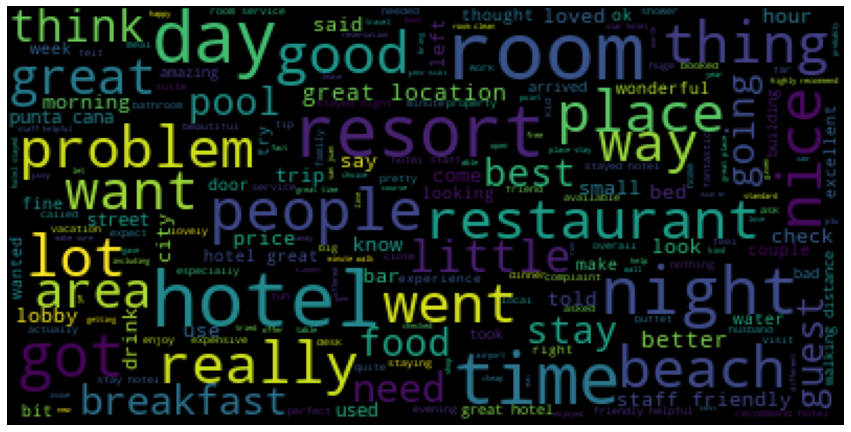

In [ ]:
show_wordcloud(df["Review"].values)

##Target Count

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "bar"}]])
colors = ['gold', 'mediumturquoise', 'lightgreen'] # darkorange
fig.add_trace(go.Pie(labels=df.label_name.value_counts().index,
                             values=df.label.value_counts().values), 1, 1)

fig.update_traces(hoverinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

fig.add_trace(go.Bar(x=df.label_name.value_counts().index, y=df.label.value_counts().values, marker_color = colors), 1,2)

fig.show()

##Token Count

#Classifier Model (Multinomial Naives Bayes)

#Fitting and Transforming

In [ ]:
from sklearn.model_selection import train_test_split
X = df['Review']
y = df['label']
X, X_test, y, y_test = train_test_split(X,y, stratify = y, test_size=0.25, random_state = 42)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(stop_words = 'english')

In [ ]:
X = vec.fit_transform(X).toarray()
X_test = vec.transform(X_test).toarray()

In [ ]:
from sklearn.naive_bayes import MultinomialNB
MNB = MultinomialNB()
MNB.fit(X, y)

MultinomialNB()

In [ ]:
MNB.score(X_test, y_test)

0.8489166504001562

#Evaluation

In [ ]:
MNB.predict(vec.transform(['Love this app simply awesome!'])) #0 negative, 1 neutral, 2 positive

array([2])

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

preds = MNB.predict(X_test)

print(classification_report(y_test, preds))

confusion_matrix(y_test, preds, normalize = 'true')

              precision    recall  f1-score   support

           0       0.78      0.78      0.78       804
           1       0.48      0.06      0.10       546
           2       0.87      0.98      0.92      3773

    accuracy                           0.85      5123
   macro avg       0.71      0.60      0.60      5123
weighted avg       0.81      0.85      0.81      5123



array([[0.77736318, 0.02363184, 0.19900498],
       [0.1978022 , 0.05677656, 0.74542125],
       [0.01722767, 0.00397562, 0.97879671]])

In [ ]:
cm_MNB = confusion_matrix(y_test.values, preds) 
cm_MNB

array([[ 625,   19,  160],
       [ 108,   31,  407],
       [  65,   15, 3693]])

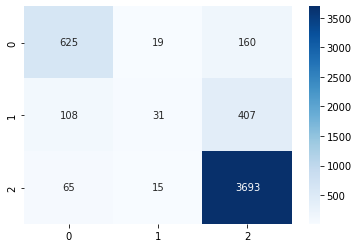

In [ ]:
sns.heatmap(cm_MNB, annot = True, cmap = 'Blues', fmt = 'g');